# Question 3 Flower Classification using CNN 
- Please **do not** change the default variable names in this problem, as we will use them in different parts.
- The default variables are initially set to "None".
- You only need to modify code in the "TODO" part. We added some "assertions" to check your code. **Do not** modify them.

In [1]:
# import statements

import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader
import random 
from tqdm import tqdm 
import warnings
import sys

You can upload your image folder on Google drive and access image folder from it. **Skip it if you run on local machine.** You May: 

*   Mount google drive to your current colab page.
*   Mount it on google colab's local storage and unzip the data.



In [2]:
#TODO
# run the following command to mount data through Google Drive
from google.colab import drive
drive.mount('/content/drive')

# OR uncomment following code, upload the dataset zip file, unzip by running the following code
!unzip /content/drive/MyDrive/Intro_to_DL/HW_4/image.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/Intro_to_DL/HW_4/image.zip
replace flowers/rose/4061451210_1650590c6a.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: flowers/rose/4061451210_1650590c6a.jpg  
replace flowers/rose/3663244576_97f595cf4a.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: flowers/rose/3663244576_97f595cf4a.jpg  
  inflating: flowers/rose/8667101118_87ea757b15.jpg  
  inflating: flowers/rose/5073473370_bdbb5a99fc.jpg  
  inflating: flowers/rose/16001846141_393fdb887e_n.jpg  
  inflating: flowers/rose/7461897058_3c955efe2a_n.jpg  
  inflating: flowers/rose/18464052396_6327841e65_n.jpg  
  inflating: flowers/rose/1645761726_2b1be95472.jpg  
  inflating: flowers/rose/16643785404_284c6c23fe_n.jpg  
  inflating: flowers/rose/3253243865_435c1f2c2b_m.jpg  
  inflating: flowers/rose/5002456302_e3d2600c17_n.jpg  
  inflating: flowers/rose/

In [3]:
# check pytorch cuda and use cuda if possible
device = torch.cuda.is_available()
print('*' * 50)
if device:  
  print('CUDA is found! Tranining on %s.......'%torch.cuda.get_device_name(0))
else:
  warnings.warn('CUDA not found! Training may be slow......')

**************************************************
CUDA is found! Tranining on Tesla T4.......



## P1. Data augmentation and plotting
### TODO
- Design your image augmentation method for transform_image
- Load train and test data, and split them into train_loader and test_loader 
- Visualize your augmented image 





In [4]:
# TODO: define your image augmentation method
# Make sure to crop the image in (3,224,224) using transforms.RandomResizedCrop(224)  
transform_image = transforms.Compose([transforms.RandomResizedCrop(224),transforms.ToTensor()])

# TODO: Load data using ImageFolder. Specify your image folder path 
path = '/content/flowers'
dataset = datasets.ImageFolder(path,transform=transform_image)

n = len(dataset)
n_test = int(0.1 * n) 

# Split data into features(pixels) and labels(numbers from 0 to 4)
train_dataset, test_dataset = random_split(dataset, (n-n_test,n_test))
train_loader, test_loader = DataLoader(train_dataset, batch_size=16, shuffle=True), DataLoader(test_dataset, batch_size=16, shuffle=True)

(-0.5, 223.5, 223.5, -0.5)

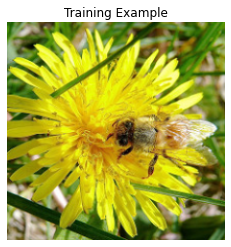

In [5]:
# # Sample output
label_map = [['daisy'],['dandelion'],['rose'],['sunflower'],['tulip']]
random_image = random.randint(0,len(train_dataset))
image = train_dataset.__getitem__(random_image)
assert np.array_equal(image[0].detach().numpy().shape, [3,224,224])
# np.array_equal(image[0], [3,224,224])
plt.imshow(image[0].permute(1,2,0))
plt.title(f"Training Example")
plt.axis('off')

## P2. Build you own CNN model 
### TODO
- Design your own model class in **CNNModel(nn.Module)** and write forward pass in **forward(self, x)**
- Create loss function in **criterion**, optimizer in **optimizer**
- Define hyparparameters: **learning_rate**, **num_epochs**
- Plot your **loss vs num_epochs** and **accuracy vs num_epochs** 
- Plot your first convolution layer kernels using **plot_filters_multi_channel()**

###  Hints
- Start with low number of epochs for debugging. (eg. num_epochs=1)
- You may want to use small learning rate for training. (eg. 1e-5)
- Be careful with the input dimension of fully connected layer. 
- The dimension calculation of the output tensor from the input tensor is \\
$D_{out}=\frac{D_{in}-K+2P}{S}+1$ \\
$D_{out}$ : Dimension of output tensor \\
$D_{in}$ : Dimension of input tensor \\
$K$ : width/height of the kernel \\
$S$ : stride \\
$P$ : padding

## Convolutional and Pooling Layers

A convolutional layer using pyTorch:



```
torch.nn.Conv2d(num_in_channels, num_out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
```
For example:
```
torch.nn.Conv2d(3, 32, 3)
```
It applies a 2D convolution over an input signal composed of several input planes. If we have input size with $(N, C_{in}, H, W)$ and output size with $(N, C_{out}, H_{out}, W_{out})$, the 2D convolution can described as $$out(N_i, C_{out_j}) = bias(C_{out_j}) + \sum_{k=0}^{C_{in}-1}weight(C_{out_j},k)\star input(N_i,k)$$

**num_in_channels:** is the number of channels of the input tensor. If the previous layer is the input layer, num_in_channels is the number of channels of the image (3 channels for RGB images), otherwise num_in_channels is equal to the number of feature maps of the previous layer.

**num_out_channels:** is the number of filters (feature extractor) that this layer will apply over the image or feature maps generated by the previous layer.

**kernel_size:** is the size of the convolving kernel
So for instance, if we have an RGB image and we are going to apply 32 filters of 3x3:

**stide:** is the stride of the convolution. Default: 1

**padding:** is the padding added to all four sides of the input. Default: 0

**dilation:** is the spacing between kernel elements. Default: 1

**group:** is the number of blocked connections from input channels to output channels. Default: 1

**bias:** If True, adds a learnable bias to the output. Default: True

## A Simple Convolutional Neural Network

In our convnet we'll use the next structure shown in the comment:

*input -> convolution -> pooling -> fully connected -> output* \\

**Convolution #1**

16 kernels of 5x5; *Width/Height:* (224 - 5 + 2x0) / 1 + 1 = 220; *Output dimensions:* (16, 220, 220)

**Max Pooling #1**

filter size = 2, stride = 2; *Width/Height:* (220 - 2) / 2 + 1 = 110; *Output dimensions:* (16, 110, 110)

So at the end of the last convolutional layer we get a tensor of dimension (16, 110, 110). And since now we are going to feed it to fully connected classifier, we need to convert it into a 1-D vector, and for that we use the reshape method:

```
x = x.view(x.size(0), -1)
```
The way of calculating size of the output size from previous convolution layer can be formulized as below: $$H_{output} = \frac{H_{in}+2\times padding-kernel\_Size}{stride}+1$$

For more details, you can refer to this link: \\
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [6]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    # TODO: Create CNNModel using 2D convolution. You should vary the number of convolution layers and fully connected layers 
    # Example:  
    # self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
    # self.relu1 = nn.ReLU() 
    # self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
    self.relu1 = nn.ReLU() 
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)
    self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
    self.relu2 = nn.ReLU() 
    self.maxpool2 = nn.MaxPool2d(kernel_size=2) 
    # TODO: Create Fully connected layers. You should calculate the dimension of the input tensor from the previous layer 
    # Example: 
    # self.fc1 = nn.Linear(16 *110 * 110, 5)
    # Fully connected 1
    self.fc1 = nn.Linear(89888 ,32)
    self.relu3 = nn.ReLU()
    self.fc2 = nn.Linear(32,5)

  def forward(self,x):
    # TODO: Perform forward pass in blow section 
    # Example:
    # out = self.cnn1(x)
    # out = self.relu1(out)      
    # out = self.maxpool1(out) 
    # out = out.view(out.size(0), -1)
    # out = self.fc1(out)
    
    out = self.cnn1(x)
    out = self.relu1(out)
    out = self.maxpool1(out)
    out = self.cnn2(out)
    out = self.relu2(out)
    out = self.maxpool2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.relu3(out)
    out = self.fc2(out)

    return out

## Starting Up Our Model

We'll send the model to our GPU if you have one so we need to create a CUDA device and instantiate our model. Then we will define the loss function and 
hyperparameters that we need to train the model: \\

###TODO
- Define Cross Entropy Loss
- Create Adam Optimizer
- Define hyperparameters 

In [7]:
# Create CNN
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNModel()
model.to(device)

# TODO: define Cross Entropy Loss 
criterion = nn.CrossEntropyLoss()

# TODO: create Adam Optimizer and define your hyperparameters 
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
num_epochs = 20

In [8]:
from torchsummary import summary
print(summary(model, input_size = (3, 224, 224), batch_size = -1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                   [-1, 32]       2,876,448
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 5]             165
Total params: 2,890,661
Trainable params: 2,890,661
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 11.03
Estimated Total Size (MB): 31.07
------------------------------------

### Training the Model
### TODO 
- Make predictions from your model
- Calculate Cross Entropy Loss from predictions and labels 

In [9]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in tqdm(range(num_epochs)):
    # model.train()
    # for i, (images, labels) in enumerate(train_loader):
    #     images, labels = images.to(device), labels.to(device)
        
    #     # Clear gradients
    #     optimizer.zero_grad()
        
    #     # TODO: Forward propagation
    #     outputs = None
        
    #     # TODO: Calculate softmax and Cross entropy loss
    #     loss = None
        
    #     # Backprop agate your Loss 
    #     loss.backward()
        
    #     # Update CNN model  
    #     optimizer.step()
        
    #     count += 1
        
    #     if count % 50 == 0:
    #         model.eval()
    #         # Calculate Accuracy         
    #         correct = 0
    #         total = 0
    #         # Iterate through test dataset
    #         for images, labels in test_loader:
    #             images, labels = images.to(device), labels.to(device)
                
    #             # Forward propagation
    #             outputs = model(images)
                
    #             # Get predictions from the maximum value
    #             predicted = torch.argmax(outputs, 1)
                
    #             # Total number of labels
    #             total += len(labels)
                
    #             correct += (predicted == labels).sum()
            
    #         accuracy = 100 * correct / float(total)
            
    #         # store loss and iteration
    #         loss_list.append(loss.data)
    #         iteration_list.append(count)
    #         accuracy_list.append(accuracy)
    #     if count % 500 == 0:
    #         # Print Loss
    #         print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Perform Forward Propagation
        outputs = model(images)
        
        # Calculate Softmax and Cross Entropy Loss
        loss = criterion(outputs, labels)
        
        # Perform Backpropagation
        loss.backward()
        
        # Update CNN model parameters
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            model.eval()
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.argmax(outputs, 1)
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum().item()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))





 10%|█         | 2/20 [00:51<07:54, 26.36s/it]

Iteration: 500  Loss: 1.71592116355896  Accuracy: 50.580046403712295 %


 20%|██        | 4/20 [01:43<06:52, 25.81s/it]

Iteration: 1000  Loss: 0.7993666529655457  Accuracy: 55.45243619489559 %


 30%|███       | 6/20 [02:34<06:00, 25.76s/it]

Iteration: 1500  Loss: 1.2844486236572266  Accuracy: 59.62877030162413 %


 40%|████      | 8/20 [03:23<05:00, 25.05s/it]

Iteration: 2000  Loss: 0.7780563235282898  Accuracy: 65.89327146171694 %


 50%|█████     | 10/20 [04:14<04:12, 25.26s/it]

Iteration: 2500  Loss: 0.8031286597251892  Accuracy: 65.19721577726219 %


 60%|██████    | 12/20 [05:05<03:23, 25.42s/it]

Iteration: 3000  Loss: 1.0415743589401245  Accuracy: 65.66125290023201 %


 70%|███████   | 14/20 [05:58<02:35, 25.86s/it]

Iteration: 3500  Loss: 0.6945046782493591  Accuracy: 69.60556844547564 %


 80%|████████  | 16/20 [06:46<01:40, 25.02s/it]

Iteration: 4000  Loss: 1.068811058998108  Accuracy: 68.44547563805105 %


 90%|█████████ | 18/20 [07:37<00:50, 25.24s/it]

Iteration: 4500  Loss: 0.7305499315261841  Accuracy: 71.46171693735499 %


100%|██████████| 20/20 [08:29<00:00, 25.46s/it]


### Visualize the Data
### TODO


*   Plot Accuracy versus Iterations Graph
*   Plot Loss versus Iterations Graph




Text(0.5, 1.0, 'Loss vs Epoch')

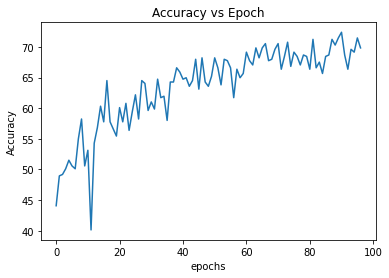

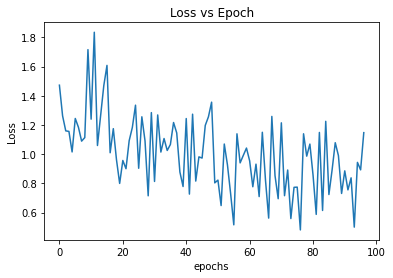

In [10]:
# visualization accuracy
#TODO: Plot Accuracy versus Iterations
plt.figure()
plt.plot(accuracy_list)
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')

# visualization loss
#TODO: Plot Loss versus Iterations 
plt.figure()
plt.plot(loss_list)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')

In [11]:
print(f'The final accuracy of the model is {accuracy_list[-1]}')

The final accuracy of the model is 69.83758700696056
